In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pylab as plt
import seaborn as sns
import os
%matplotlib inline

# Facebook Check Ins
On Facebook, a user can check into a nearby location by selecting from a list of close locations from their GPS location, or by manually selecting a location. This posts to their social group that they are currently at the selected location and highlights the business or location they checked in to. The goal of this challenge, provided by Facebook, is to predict the check in location given only the location (with accuracy), and time. A large dataset has been provided with artifical data.

First, we will read in the data and do some preliminary exploration.

In [87]:
p = '/Users/dpyne/Documents/ML Data/Facebook Check Ins'
df = pd.read_csv(os.path.join(p, 'train.csv'), index_col='row_id', nrows=100000)
final = pd.read_csv(os.path.join(p, 'test.csv'), index_col='row_id', nrows=100000)

We can see that about 2.9 million data points have been provided. X and Y coordinates fall from 0 to 10 (were stated to have been given in kms) and accuracy falls from 1 to about 1000, although no further description was given. Time ranges from 1 to about 786 000 and no information about units was given. We will have to figure this out later.

In [88]:
df.describe()

,x,y,accuracy,time,place_id
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,4.982292,4.989130,82.482670,417559.598670,5.489778e+09
std,2.858019,2.894304,114.491608,230801.226212,2.602287e+09
min,0.000600,0.000200,1.000000,61.000000,1.000025e+09
25%,2.520700,2.481575,27.000000,203630.750000,3.229876e+09
50%,4.989500,4.972250,62.000000,434849.000000,5.512858e+09
75%,7.444100,7.505300,75.000000,620717.250000,7.744427e+09
max,9.999900,9.999900,1009.000000,786239.000000,9.999917e+09


## Location and Places
There does not appear to be any trend in the location data on the large scale.

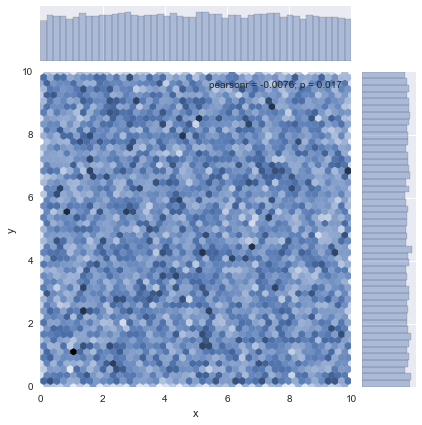

In [4]:
sns.jointplot(df['x'], df['y'], kind='hex')

We can then look at the distribution in check-ins across places. 

Total number of places: 52883


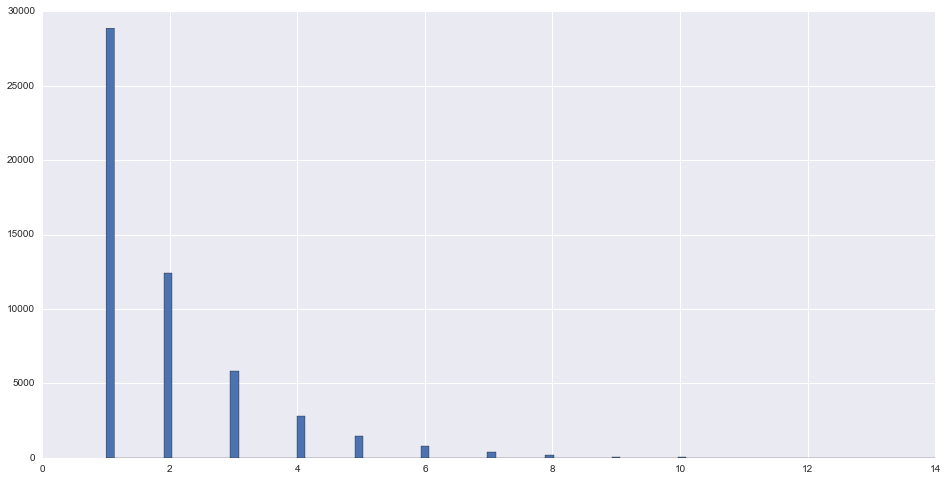

In [89]:
place_grouped = df.groupby('place_id')
print('Total number of places: %s' % len(place_grouped))
place_grouped.size().hist(bins=100, figsize=(16,8))

Let's look specifically at the check in locations for the top places.

In [90]:
highest_place_ids = place_grouped.size().sort_values(ascending=False)[:20].index
highest_places_df = df[df['place_id'].isin(highest_place_ids)]

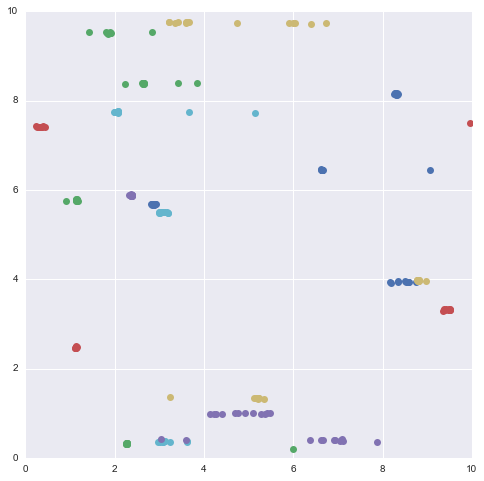

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
for place_id, group in highest_places_df.groupby('place_id'):
    ax.plot(group['x'], group['y'], 'o')
ax.set_ylim([0,10])
ax.set_xlim([0, 10])
plt.show()

It seems that locations are very tightly grouped along the y-axis but very wide along the x-axis. Perhaps this coresponds to streets in this fictional city. Although we would expect to see vertical streets as well. We will need to keep this in mind when building a model as we will need to scale these axis accordingly.

To check if this observation holds true for all of our place ids, we can check the distribution of the standard deviation of each place id along each axis.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10eb6ec18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ebc2ef0>]], dtype=object)

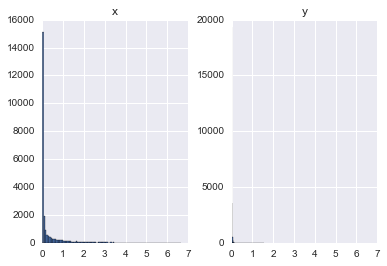

In [8]:
place_grouped[['x','y']].std().hist(bins=100, sharex=True)

## Accuracy
Descriptions of the data fields were intentionally left vague so we are challenged to interpret them ourselves. Let's assume that accuracy is referencing the location information. GPS accuracy is typically given as a confidence interval. For instance, 5 would mean that the location is accurate to within a 5m radius with a high degree of confidence. If this is the case we would expect most points to have a small accuracy number with a long tail where users had a weaker connection to the GPS satelittes, the weather was poor, their device fell back to using wifi based location or other less then ideal conditions.

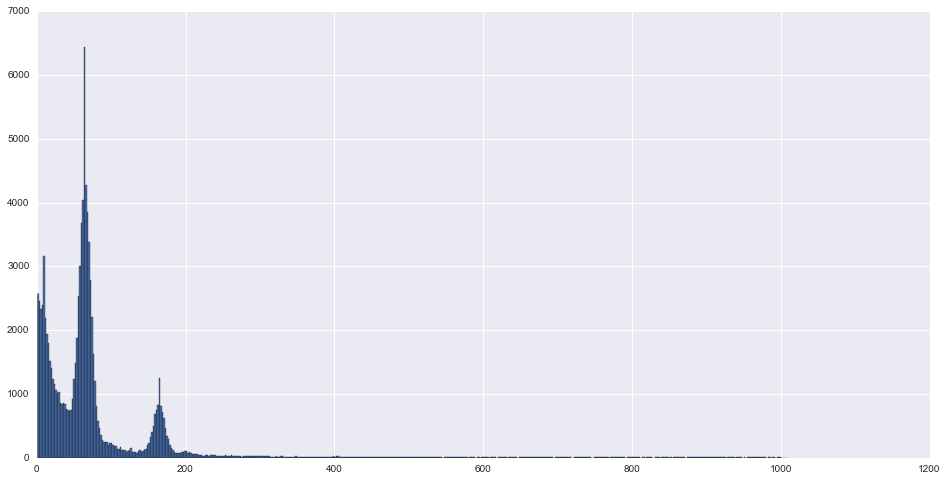

In [9]:
df['accuracy'].hist(bins=500, figsize=(16,8))

We can see a pretty interesting distribution in accuracy with three distinct peaks. This may correspond to discrete modes on the devices such as high/low precision GPS or wifi-only. Unfortunately we do not have user_ids for each check-in point otherwise we could check if the accuracy switches between mode for a given user. If the accuracy was constant for a given user we may have been able to infer the quality of the device they were using which may have been a usefull feature.

Let's check if there is any dependence between the variance in the x and y coordinates for each group and the median accuracy. We had assumed that accuracy referred to a radial distance but it might refer to a single axis.

We can see below that for each place id, there is no correlation between the distribution in either axis and the median accuracy.

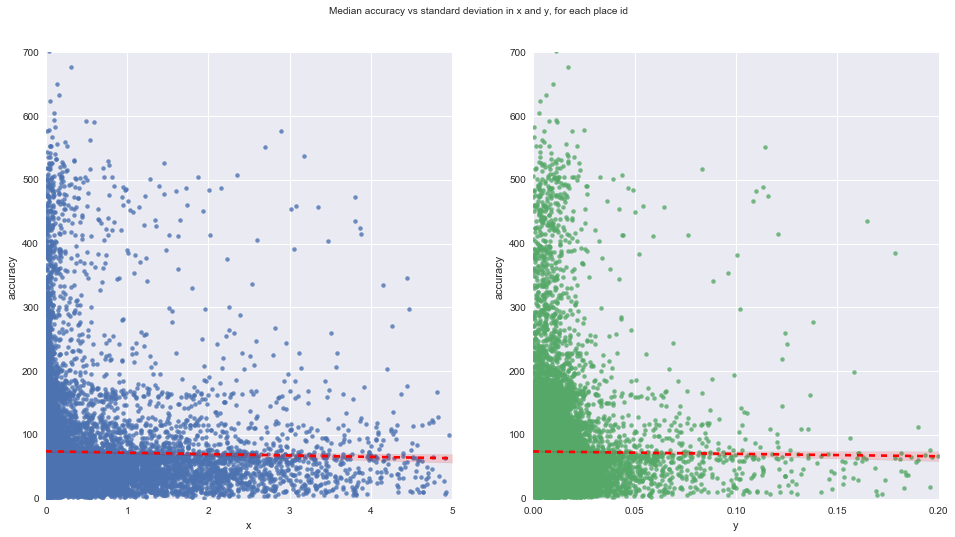

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
for coord, ax in zip(['x', 'y'], axs):
    sns.regplot(x=place_grouped[coord].std(), y=place_grouped['accuracy'].median(), 
                truncate=True, ax=ax, line_kws={'color': 'red', 'linestyle': '--'})
    ax.set_ylim([0, 700])
axs[0].set_xlim([0, 5]); axs[1].set_xlim([0, 0.2])
fig.suptitle('Median accuracy vs standard deviation in x and y, for each place id')

Let's see if there are overall any low accuracy zones.

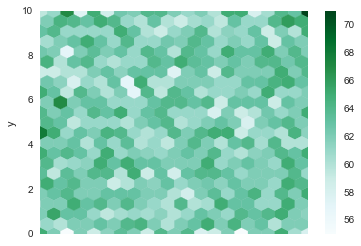

In [11]:
# Computationally intensive if using entire dataset
# df.plot.hexbin('x', 'y', C='accuracy', reduce_C_function=np.median, gridsize=20)

It seems that accuracy is a measure of the error, meaning that smaller values correspond to a more accurate reading.

## Accuracy and distance from place centroids
We will use the centroid of all check ins locations at a given place id as an approximate location of the actual place. We would then expect to see a trend with precision decreasing with distance away from the centroid. We will do this calculation for a subset of places as it is computationally expensive.

In [12]:
centroid_df = highest_places_df.groupby('place_id').apply(lambda df: Series({'x_mean': df['x'].mean(), 
                                                                             'y_mean': df['y'].mean()}))

(0, 900)

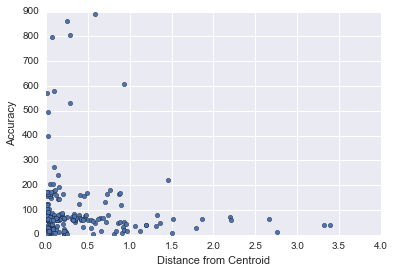

In [13]:
def dist_from_centroid(df):
    x = (df['x'] - centroid_df.ix[df['place_id']]['x_mean'])**2
    y = (df['y'] - centroid_df.ix[df['place_id']]['y_mean'])**2
    dist = np.sqrt(x+y)
    return dist
DataFrame({'Distance from Centroid': highest_places_df.apply(dist_from_centroid, axis=1),
           'Accuracy': highest_places_df['accuracy']}).plot(kind='scatter', x='Distance from Centroid', y='Accuracy')
plt.xlim([0, 4])
plt.ylim([0, 900])

We see no correlation here suggesting that larger check in distances from the actual location (assumed to be the centroid) are caused by some other activity of the user and not the actual accuracy of the location measurement.

## Unlocking time
Time is given as an int from 0 to about 800 000. We are left to figure out the units on our own. Let's start by looking at the check in quantity as a function of time.

In [14]:
usage_count, usage_time = np.histogram(df['time'], bins=2500)
usage_time = usage_time[:-1]
fs = 1./(usage_time[1] - usage_time[0])

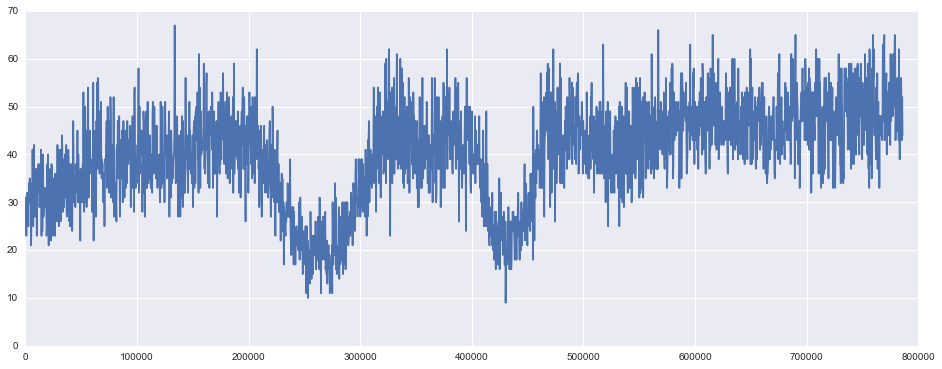

In [15]:
plt.subplots(1, 1, figsize=(16, 6))
plt.plot(usage_time, usage_count)

We can see a high frequency cycle on top of a lower frequency trend. We can do an FFT on this data to pull out the higher frequency components. These most likely correspond to the day and week cycles.

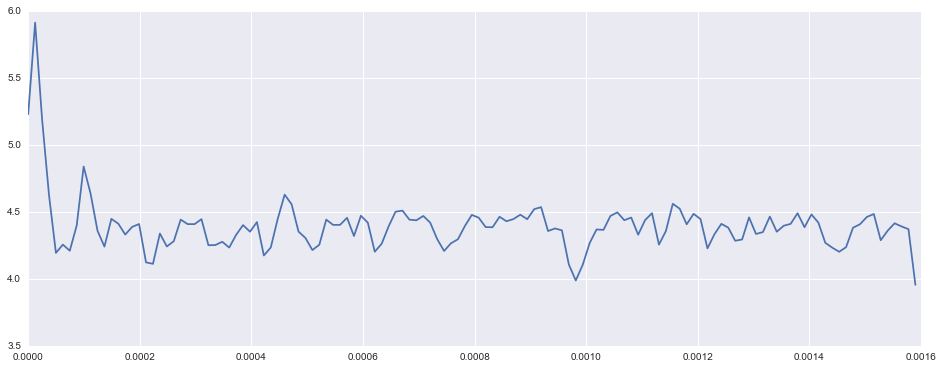

In [16]:
from scipy import signal
f, Pxx_den = signal.welch(usage_count - np.mean(usage_count), fs, nperseg=256)
plt.figure(figsize=(16,6))
plt.plot(f, np.log10(Pxx_den))

In [17]:
psd = Series(Pxx_den)
f_day = f[psd[f > 0.00015].idxmax()]
f_week = f[psd[f > 0.00005].idxmax()]

In [19]:
print(1/f_day)

2175.80073514


This gives us a week of 10063 units. This is conveniently close to the number of minutes in a week which is 10080. We can conclude that time is given in units of minutes.

We can now make a new cyclic time feature that is the fractional completion of each current week and day. We then remove the mean and give it a range of 2 for feature scaling later on.

In [91]:
df['week'] = df['time'] % 10080. / 10080 * 2 - 1.
df['day'] = df['time'] % 1440. / 1440. * 2 - 1

We can check that our data looks cyclic with these day and week lengths.

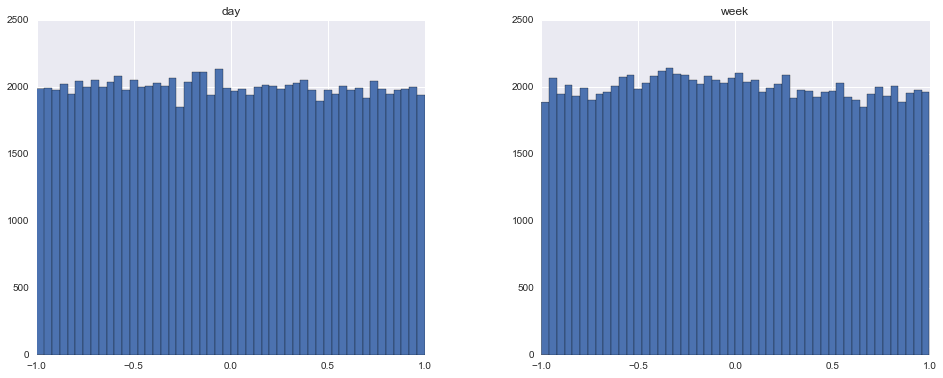

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for cycle, ax in zip(['day', 'week'], axs):
    df.hist(column=cycle, bins=50, figsize=(18,6), ax=ax)
# plt.ylim([500000,650000])

Let's look at the time distribution for some of our top places to see how unique these locations are.

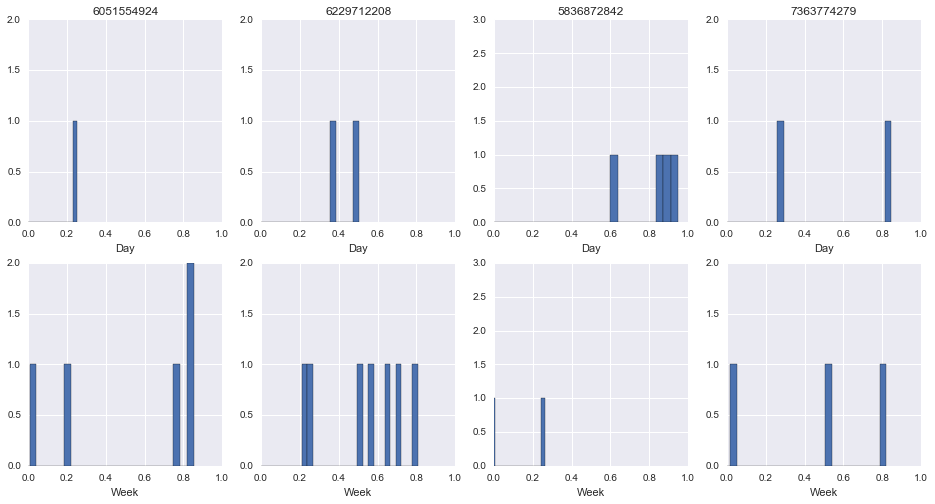

In [29]:
fig, axs  = plt.subplots(2, 4, figsize=(16, 8))
for i, (ax_day, ax_week) in enumerate(zip(axs[0], axs[1])):
    place = highest_place_ids[i]
    df[df['place_id'] == place]['day'].hist(bins=50, ax=ax_day)
    ax_day.set_title(place)
    ax_day.set_xlabel('Day')
    ax_day.set_xlim([0, 1])
    df[df['place_id'] == place]['week'].hist(bins=50, ax=ax_week)
    ax_week.set_xlabel('Week')
    ax_week.set_xlim([0, 1])

# Standardizing the data
We will be using variations of knn so it is very important that we normalize our data set. We already scaled our day and week measures earlier. To scale x and y coordinates, we will calculate the weighted average of the standard deviation for each place group. We will then transform each axis by this average. This is particularily important since we know that the location data has much greater variance along the x coordinate.

When standardizing, we will over

In [92]:
x_std_mean = place_grouped['x'].std().mean()
y_std_mean = place_grouped['y'].std().mean()

n_total = len(df)
# place_grouped.apply(lambda df: df['x'].std() * len(df) / float(n_total)).sum()
print(x_std_mean, y_std_mean)
df['x']  = df['x'] / x_std_mean
df['y']  = df['y'] / y_std_mean

0.316896263537 0.0122139248055


In [95]:
from sklearn.cross_validation import train_test_split
ml_cols = ['x', 'y', 'day', 'week']
X = df[ml_cols]
y = df['place_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Top places kNN model
Since we have such a large number of labels (places), techniques such a logistic regression that typically use a one-vs-all technique for multiclass problems, will have to train a model for all ~100 000 places. Since the dataset is also so large, we will try a nearest neighbors model to start. Since the computational requirements of knn also grow linearly with the dataset size, we will use a dataset with only the top 10000 locations.

In [98]:
n_top_places = 10000
place_grouped.size().sort_values(ascending=False)[:n_top_places].sum()

41507

In [99]:
top_places = place_grouped.size().sort_values(ascending=False)[:n_top_places].index

In [100]:
X_train_top = X_train.ix[y_train.isin(top_places)]
y_train_top = y_train.ix[y_train.isin(top_places)]

In [102]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train_top, y_train_top)

In [103]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn.predict(X_test))

0.086454545454545451

# Training Grid KNN

In [104]:
class gridKNN(object):
    '''Grid KNN Classifier

    Parameters
    ----------
    feature_res : 1d-array
        Resolution for splitting each feature
    n_pred: int (default: 3)
        Number of predictions returned per 
        data point

    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting
    errors_ : list
        Number of misclassifications in every epoch.
    '''
    def __init__(self, feature_res, n_pred=3):
        self.feature_res = feature_res
        self.n_pred=n_pred

    def fit(self, X, y):
        '''Fit training data

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples
            is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        '''
        pass
    
    def _generateGrid(self):
        pass

    def predict(self, X):
        pass